This notebook is written to check whether `thingsvision` and `harmonization` provide the same feature outputs for the harmonizer models.

In [1]:
from os.path import basename, join

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from harmonization.models import load_ResNet50, preprocess_input
from PIL import Image
from tensorflow.keras.models import Model
from thingsvision import get_extractor
from thingsvision.utils.data import ImageDataset, DataLoader

2024-11-17 14:16:38.218362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /p/software/juwelsbooster/stages/2024/software/Python/3.11.3-GCCcore-12.3.0/lib:/p/software/juwelsbooster/stages/2024/software/OpenSSL/1.1/lib:/p/software/juwelsbooster/stages/2024/software/libffi/3.4.4-GCCcore-12.3.0/lib64:/p/software/juwelsbooster/stages/2024/software/XZ/5.4.2-GCCcore-12.3.0/lib:/p/software/juwelsbooster/stages/2024/software/SQLite/3.42.0-GCCcore-12.3.0/lib:/p/software/juwelsbooster/stages/2024/software/Tcl/8.6.13-GCCcore-12.3.0/lib:/p/software/juwelsbooster/stages/2024/software/libreadline/8.2-GCCcore-12.3.0/lib:/p/software/juwelsbooster/stages/2024/software/ncurses/6.4-GCCcore-12.3.0/lib:/p/software/juwelsbooster/stages/2024/software/bzip2/1.0.8-GCCcore-12.3.0/lib:/p/software/juwelsbooster/stages/2024/software/binutils/2.

2024-11-17 14:16:53.263602: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-17 14:16:53.263741: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jwlogin22.juwels): /proc/driver/nvidia/version does not exist
2024-11-17 14:16:53.268835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


/p/project1/hai_tdllama/harmonizer_thingsvision_check/my_env/lib64/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/p/project1/hai_tdllama/harmonizer_thingsvision_check/my_env/lib64/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.3 and is not supported. 
Some things might work, some thin

## Feature extraction using the models directly

We remove the final layer of a harmonized ResNet50 and get the output of the `avg_pool`

In [2]:
model = load_ResNet50()
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output) # remove the head

n_layers = len(feature_extractor.layers)

# print just the last few layers
# we want to check if the avg_pool is the final one
for layer in feature_extractor.layers[-3:]:
    print(layer.name, layer.output_shape)

add_15 (None, 7, 7, 2048)
activation_48 (None, 7, 7, 2048)
avg_pool (None, 2048)


Load an image from the THINGS database.

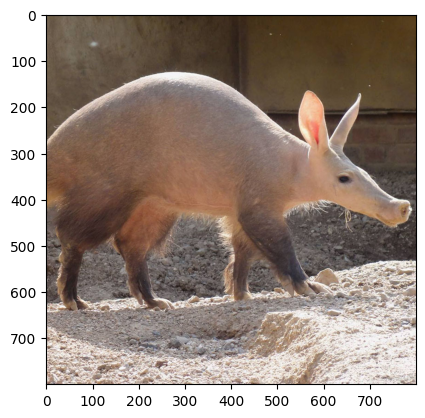

In [3]:
img = Image.open("stimuli/aardvark_01b.jpg")
plt.imshow(img)
plt.show()

Resizing to $224 \times 224$, as that's what [seems to do as well](https://github.com/ViCCo-Group/thingsvision/blob/aac5fe061d0464d92ed8adbb45d3ab550cd251c0/thingsvision/core/extraction/tensorflow.py#L82).

In [4]:
resize_dim = 224
inputs = tf.keras.utils.img_to_array(img)
resize = tf.keras.layers.Resizing(resize_dim, resize_dim)
inputs = resize(inputs)
inputs = tf.expand_dims(inputs,0) # add batch

Finally, there is the additional preprocessing, which scales the RGB values between $0$ and $1$, and applies the imagenet scaling parameters to the images.

In [5]:
original_features = feature_extractor(preprocess_input(inputs))
original_features = original_features.numpy().squeeze() # no batch

## Feature extraction using thingsvision

Follows from [here](https://thingsvision.github.io/AvailableModels.html#harmonization) and [here](https://thingsvision.github.io/GettingStarted.html)

In [6]:
model_name = 'Harmonization'
source = 'custom'
device = 'cpu'
model_parameters = {
    'variant': 'ResNet50'
}

extractor = get_extractor(
  model_name=model_name,
  source=source,
  device=device,
  pretrained=True,
  model_parameters=model_parameters
)

dataset = ImageDataset(
  root='stimuli',
  out_path='features',
  backend=extractor.get_backend(),
  transforms=extractor.get_transformations()
)

batches = DataLoader(
  dataset=dataset,
  batch_size=1, 
  backend=extractor.get_backend()
)

thingsvision_features = extractor.extract_features(
  batches=batches,
  module_name="avg_pool",
).squeeze()

/p/project1/hai_tdllama/harmonizer_thingsvision_check/my_env/lib64/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)



Using device: cpu


...Creating dataset.


Batch:   0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 1s 863ms/step


...Features successfully extracted for all 1 images in the database.
...Features shape: (1, 2048)


## Comparing features

In [7]:
np.isclose(thingsvision_features, original_features).all()

False

The outputs are not similar.

In [8]:
original_features

array([0.00364168, 0.7332883 , 0.        , ..., 0.01520281, 0.        ,
       0.68661726], dtype=float32)

In [9]:
thingsvision_features

array([  23.326593 ,  665.3451   ,   20.89124  , ...,    4.9723854,
       3508.7717   ,  259.42136  ], dtype=float32)

Maybe thingsvision doesn't scale between $0$ and $1$?

In [10]:
print(original_features.mean(), original_features.max())

0.4326719 7.7052507


In [11]:
print(thingsvision_features.mean(), thingsvision_features.max())

925.2151 48066.555


This seems plausible, as the numbers from the thingsvision features are on a much larger scale.